In [121]:
import pandas as pd
import folium
import locale
import requests
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Introduction: IRS Data and Foursquare Amenities

For the final capstone project of the <a href = "https://www.coursera.org/learn/applied-data-science-capstone">Applied Data Science</a> unit, it's required to use the Foursquare API and some other data source to analyze a problem.

Using the FourSquare API, I'm interested in amenities in rich and poor neighborhoods in the United States and to see if there is a measure of commonality or divergence and if so, how this commonality or diverence can be expressed.

## Data used to solve the problem:

It's necessary pull in some data about the wealth of the US in order for this analysis.  The Internal Revenue Service (IRS) publishes some data about the tax returns based on ZIP codes.

<a href = "https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi">This information is located here at the IRS - Individual Income Tax Statistics</a>

The average Adjusted Gross Income (AGI) of the taxpayers within a ZIP code will be used as a metric of wealth.

ZIP Codes are not geographical, so it'll be necessary to lookup each ZIP code and get Geocode pairs.  I will use the Geocoders API or a lookup via a table like <a href = "https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/">this (OpenData)</a>

The FourSquare API can be used to lookup amentities given a latitude, longitude and tagged: Lexington, MA, 42120 (42.452895, -71.21619)

FourSquare will report the number and type of amentities given this data.

In [122]:
irs = pd.read_csv("17zpallagi.csv", encoding="ISO-8859-1")

In [123]:
irs.head()

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,1,802640.0,474470.0,99850.0,216600.0,717050.0,44090.0,...,0.0,0.0,64680.0,53602.0,700940.0,1803125.0,698100.0,1796343.0,2860.0,4917.0
1,1,AL,0,2,499070.0,218590.0,137460.0,129760.0,448190.0,26230.0,...,0.0,0.0,77660.0,118725.0,419640.0,1175607.0,416180.0,1165352.0,4250.0,8894.0
2,1,AL,0,3,268590.0,89780.0,134440.0,38280.0,241060.0,14160.0,...,0.0,0.0,67820.0,156752.0,201030.0,560461.0,197060.0,547812.0,5440.0,13482.0
3,1,AL,0,4,170880.0,32180.0,124070.0,11660.0,154120.0,7980.0,...,0.0,0.0,48440.0,141721.0,121930.0,396526.0,118460.0,383588.0,3160.0,12369.0
4,1,AL,0,5,229870.0,22810.0,196990.0,5540.0,208380.0,11120.0,...,50.0,19.0,91100.0,465160.0,138250.0,588068.0,130970.0,529001.0,8430.0,55564.0


The headings for the IRS are rather cryptic. "N1" is the amount of filings in 1000s.
A00100 is the reported income "AGI".  It's reported in bands of incomes, we need to create an weighted average across those income bands.

In [124]:
irs['income'] = irs['A00100']*1000 / irs['N1']

In [125]:
df = irs[{'STATE','zipcode','N1','income','A00100'}]
df.dropna(inplace = True)
df.head(20)

C:\Users\rober\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,STATE,zipcode,A00100,N1,income
0,AL,0,10467448.0,802640.0,13041.273796
1,AL,0,17977581.0,499070.0,36022.163224
2,AL,0,16502473.0,268590.0,61441.129603
3,AL,0,14817087.0,170880.0,86710.481039
4,AL,0,31131390.0,229870.0,135430.417192
5,AL,0,28677141.0,62610.0,458028.126497
6,AL,35004,19889.0,1500.0,13259.333333
7,AL,35004,50071.0,1340.0,37366.417910
8,AL,35004,56574.0,920.0,61493.478261
9,AL,35004,55894.0,650.0,85990.769231


In [126]:
zc = df.groupby('zipcode')
ztest = zc.sum()

ztest = ztest.drop(['A00100','income'], axis=1)

ztest.loc[30002]
ztest.rename(columns = {'N1':'N1_SUM'}, inplace = True) 
ztest.head()

,N1_SUM
zipcode,
0,149639420.0
1001,9060.0
1002,9530.0
1005,2400.0
1007,7630.0


In [127]:
irs = irs.merge(ztest,on='zipcode')
irs.loc[irs['zipcode']==30002]

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,income,N1_SUM
27812,13,GA,30002,1,850.0,600.0,70.0,170.0,760.0,30.0,...,110.0,107.0,690.0,1628.0,680.0,1604.0,0.0,0.0,13500.000000,3120.0
27813,13,GA,30002,2,630.0,400.0,80.0,130.0,560.0,30.0,...,130.0,187.0,490.0,1131.0,480.0,1117.0,0.0,0.0,35803.174603,3120.0
27814,13,GA,30002,3,390.0,250.0,80.0,40.0,340.0,30.0,...,100.0,255.0,280.0,797.0,280.0,757.0,40.0,107.0,61038.461538,3120.0
27815,13,GA,30002,4,300.0,150.0,110.0,30.0,270.0,0.0,...,90.0,269.0,210.0,672.0,200.0,541.0,0.0,0.0,87280.000000,3120.0
27816,13,GA,30002,5,610.0,140.0,420.0,50.0,550.0,50.0,...,250.0,1135.0,360.0,1518.0,340.0,1412.0,30.0,106.0,139354.098361,3120.0
27817,13,GA,30002,6,340.0,30.0,300.0,0.0,310.0,0.0,...,170.0,3037.0,170.0,1970.0,140.0,1143.0,40.0,827.0,382288.235294,3120.0


In [128]:
irs['weighted_avg_p'] = irs['N1']/irs['N1_SUM']
# let's check the results for one zip code
irs.loc[irs['zipcode']==30002]

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,A11901,N11900,A11900,N11902,A11902,N12000,A12000,income,N1_SUM,weighted_avg_p
27812,13,GA,30002,1,850.0,600.0,70.0,170.0,760.0,30.0,...,107.0,690.0,1628.0,680.0,1604.0,0.0,0.0,13500.000000,3120.0,0.272436
27813,13,GA,30002,2,630.0,400.0,80.0,130.0,560.0,30.0,...,187.0,490.0,1131.0,480.0,1117.0,0.0,0.0,35803.174603,3120.0,0.201923
27814,13,GA,30002,3,390.0,250.0,80.0,40.0,340.0,30.0,...,255.0,280.0,797.0,280.0,757.0,40.0,107.0,61038.461538,3120.0,0.125000
27815,13,GA,30002,4,300.0,150.0,110.0,30.0,270.0,0.0,...,269.0,210.0,672.0,200.0,541.0,0.0,0.0,87280.000000,3120.0,0.096154
27816,13,GA,30002,5,610.0,140.0,420.0,50.0,550.0,50.0,...,1135.0,360.0,1518.0,340.0,1412.0,30.0,106.0,139354.098361,3120.0,0.195513
27817,13,GA,30002,6,340.0,30.0,300.0,0.0,310.0,0.0,...,3037.0,170.0,1970.0,140.0,1143.0,40.0,827.0,382288.235294,3120.0,0.108974


In [129]:
irs['weighted_avg_dollar'] = irs['weighted_avg_p'] * irs['income']
irs.loc[irs['zipcode']==30002]
uirs = irs[{'STATEFIPS', 'STATE', 'zipcode', 'agi_stub', 'N1','income','N1_SUM', 'weighted_avg_p', 'weighted_avg_dollar'}]

In [130]:
uirs = uirs.drop(uirs[uirs['zipcode'] == 0].index)
uirs.loc[uirs['zipcode']==30002]

,STATE,agi_stub,STATEFIPS,weighted_avg_dollar,zipcode,weighted_avg_p,N1,N1_SUM,income
27812,GA,1,13,3677.884615,30002,0.272436,850.0,3120.0,13500.000000
27813,GA,2,13,7229.487179,30002,0.201923,630.0,3120.0,35803.174603
27814,GA,3,13,7629.807692,30002,0.125000,390.0,3120.0,61038.461538
27815,GA,4,13,8392.307692,30002,0.096154,300.0,3120.0,87280.000000
27816,GA,5,13,27245.512821,30002,0.195513,610.0,3120.0,139354.098361
27817,GA,6,13,41659.615385,30002,0.108974,340.0,3120.0,382288.235294


## We now have our weighted average for Zipcodes

In [131]:
zc = uirs.groupby('zipcode')
ztest = zc.sum()

#let's check the average income in ZIPCODE 30022.  Looks like $95,834
ztest.loc[30002]

agi_stub                   21.000000
STATEFIPS                  78.000000
weighted_avg_dollar     95834.615385
weighted_avg_p              1.000000
N1                       3120.000000
N1_SUM                  18720.000000
income                 719263.969796
Name: 30002, dtype: float64

In [132]:
ztest.index

Int64Index([ 1001,  1002,  1005,  1007,  1008,  1010,  1011,  1012,  1013,
             1020,
            ...
            99743, 99760, 99780, 99801, 99824, 99827, 99833, 99835, 99901,
            99999],
           dtype='int64', name='zipcode', length=27659)

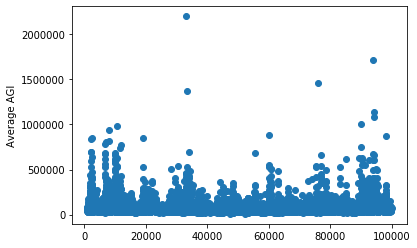

In [133]:
# Let's just visualize the distribution of incomes across zipcodes
import matplotlib.pyplot as plt
import numpy as np
plt.ylabel('Average AGI')
plt.scatter(ztest.index,ztest['weighted_avg_dollar'])



In [134]:
# who has the maximum income?
ztest.loc[ztest['weighted_avg_dollar'] == ztest['weighted_avg_dollar'].max()]

,agi_stub,STATEFIPS,weighted_avg_dollar,weighted_avg_p,N1,N1_SUM,income
zipcode,,,,,,,
33109,21,72,2.198236e+06,1.0,280.0,1680.0,3.847401e+06


Some big ballers down in Florida.

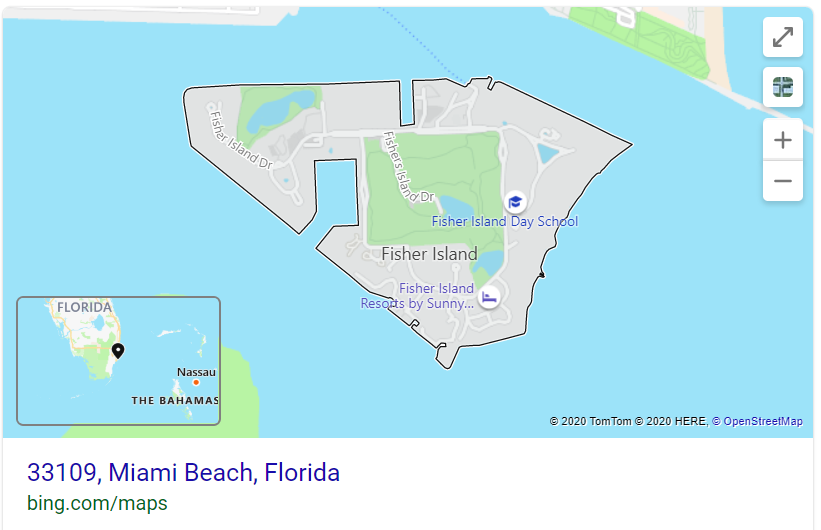

### You can use the Geocoders API to get a geocode, but it's waay too slow.  I used this instead:
https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/

In [135]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = '30022, USA'

geolocator = Nominatim(user_agent="irs_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the address are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the address are 34.020029, -84.276656.


In [136]:
#ztest.index.tolist()

def make_coords():
    zips = ztest.index.tolist()
    zips
    lats = []
    long = []
    index = 0

    for z in zips:
        address = str(z) + ", USA"
        geolocator = Nominatim(user_agent="irs_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lats.append(latitude)
        long.append(longitude)
        index = index + 1
        print(index)

    

In [137]:
#irs = pd.read_csv("17zpallagi.csv", encoding="ISO-8859-1")
ztest

,agi_stub,STATEFIPS,weighted_avg_dollar,weighted_avg_p,N1,N1_SUM,income
zipcode,,,,,,,
1001,21,150,58486.754967,1.0,9060.0,54360.0,6.772506e+05
1002,21,150,89690.346275,1.0,9530.0,57180.0,7.469949e+05
1005,21,150,59252.916667,1.0,2400.0,14400.0,5.975462e+05
1007,21,150,74135.386632,1.0,7630.0,45780.0,6.388274e+05
1008,21,150,65713.846154,1.0,650.0,3900.0,3.436296e+05
...,...,...,...,...,...,...,...
99827,21,12,60612.500000,1.0,1280.0,7680.0,8.011578e+05
99833,21,12,67992.982456,1.0,1710.0,10260.0,6.779568e+05
99835,21,12,70918.876404,1.0,4450.0,26700.0,8.626467e+05


In [138]:
zipcode = pd.read_csv("us-zip-code-latitude-and-longitude.csv", sep=';',encoding="ISO-8859-1")

In [139]:
#the data from this dataset has ZIPCODE, City State and Lat/Long
zipcode.rename(columns = {'Zip':'zipcode'}, inplace = True) 
zipcode.head()

,zipcode,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,48834,Fenwick,MI,43.141649,-85.04948,-5,1,"43.141649,-85.04948"
1,55304,Andover,MN,45.254715,-93.28652,-6,1,"45.254715,-93.28652"
2,55422,Minneapolis,MN,45.014764,-93.33965,-6,1,"45.014764,-93.33965"
3,29079,Lydia,SC,34.296064,-80.11319,-5,1,"34.296064,-80.11319"
4,29390,Duncan,SC,34.888237,-81.96902,-5,1,"34.888237,-81.96902"


In [140]:
ztest = ztest.merge(zipcode,on='zipcode')

In [141]:
ztest.rename(columns = {'weighted_avg_dollar':'Average AGI'}, inplace = True) 
#ztest.to_csv('zip_er.csv')

### Here are the top 5 richest ZIP codes.

In [142]:
#some nice formatting.richest 40 zip codes
rich = ztest.sort_values(by=['Average AGI'], ascending=False)
rich.head()
#rich.loc[rich.index[0]]
#print ('${:,.0f}'.format(rich.loc[rich.index[0]]['Average AGI']))

,zipcode,agi_stub,STATEFIPS,Average AGI,weighted_avg_p,N1,N1_SUM,income,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
8977,33109,21,72,2.198236e+06,1.0,280.0,1680.0,3.847401e+06,Miami Beach,FL,25.759474,-80.13907,-5,1,"25.759474,-80.13907"
25861,94027,21,36,1.718305e+06,1.0,3240.0,19440.0,3.813630e+06,Atherton,CA,37.458615,-122.20009,-8,1,"37.458615,-122.20009"
22395,76102,21,288,1.455423e+06,1.0,4340.0,26040.0,1.305899e+07,Fort Worth,TX,32.753880,-97.32987,-6,1,"32.75388,-97.32987"
9112,33480,21,72,1.369855e+06,1.0,5880.0,35280.0,3.754224e+06,Palm Beach,FL,26.715067,-80.03937,-5,1,"26.715067,-80.03937"
25884,94104,21,36,1.133140e+06,1.0,1290.0,7740.0,3.596518e+06,San Francisco,CA,37.791728,-122.40190,-8,1,"37.791728,-122.4019"


### We're going to create a map showing <font color='Green'>Rich</font> and <font color='Red'>Poor</font>
In case my HTML doesn't survive the viewing on GitHub, Rich are Green.  Poor are Red.

In [143]:
# create map using latitude and longitude values
latitude = ztest.loc[ztest['Average AGI'] == ztest['Average AGI'].max()].Latitude
longitude = ztest.loc[ztest['Average AGI'] == ztest['Average AGI'].max()].Longitude

map_rich_n_poor = folium.Map(location=[latitude, longitude], zoom_start=4)

# add top 40 markers to map
for x in range(40):
    temp = rich.loc[rich.index[x]]
    label = '{}, {}'.format(temp.City, temp.State)
    label = label + " "+ '${:,.0f}'.format(rich.loc[rich.index[x]]['Average AGI'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [temp.Latitude, temp.Longitude],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00cc66',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rich_n_poor)

poor = ztest.sort_values(by=['Average AGI'])

for x in range(40):
    temp = poor.loc[poor.index[x]]
    label = '{}, {}'.format(temp.City, temp.State)
    label = label + " "+ '${:,.0f}'.format(poor.loc[poor.index[x]]['Average AGI'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [temp.Latitude, temp.Longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0066',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rich_n_poor)

#folium.Marker(location=[43.141649,-85.04948],icon=folium.Icon(color='green',icon='money',prefix='fa')).add_to(map_rich_n_poor)

map_rich_n_poor

In [144]:
from fsq import CLIENT_ID
from fsq import CLIENT_SECRET
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

In [145]:
def getNearbyVenues(tag,zipcode,name, latitude, longitude, radius=500):
    
    venues_list=[]

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, latitude, longitude, 
        radius, 
        LIMIT)
                    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    if (len(results) > 0):

        # return only relevant information for each nearby venue
        venues_list.append([(tag,zipcode,
            name, 
            latitude, 
            longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['tag','zipcode','City', 
                      'Latitude', 
                      'Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']

    else:
        
        nearby_venues = pd.DataFrame(columns = ['tag','zipcode','City', 
                      'Latitude', 
                      'Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category'])
        
        
        
        
    return(nearby_venues)

In [146]:
zip_code_results = pd.DataFrame(columns=['tag','zipcode','City', 'Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
for x in range(40):
    temp = rich.loc[rich.index[x]]
    label = '{}, {}'.format(temp.City, temp.State)
    zip_code_results= zip_code_results.append(getNearbyVenues('rich',temp.zipcode,label,temp.Latitude, temp.Longitude))

for x in range(40):
    temp = poor.loc[poor.index[x]]
    label = '{}, {}'.format(temp.City, temp.State)
    zip_code_results= zip_code_results.append(getNearbyVenues('poor',temp.zipcode,label,temp.Latitude, temp.Longitude))


In [147]:
zip_code_results.groupby('tag').count()

,zipcode,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
tag,,,,,,,,
poor,360,360,360,360,360,360,360,360
rich,1134,1134,1134,1134,1134,1134,1134,1134


As we might expect, there's a lot more amentities (at least covered by Foursquare) in rich areas than poor ones.

In [148]:
# one hot encoding
zc_onehot = pd.get_dummies(zip_code_results[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zc_onehot['City'] = zip_code_results['City'] 
zc_onehot['tag'] = zip_code_results['tag'] 

# move neighborhood column to the first column
fixed_columns = [zc_onehot.columns[-1]] + list(zc_onehot.columns[:-1])
zc_onehot = zc_onehot[fixed_columns]
zc_grouped = zc_onehot.groupby('tag').mean().reset_index()

num_top_venues = 15

for hood in zc_grouped['tag']:
    print("----"+hood+"----")
    temp = zc_grouped[zc_grouped['tag'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')



----poor----
                        venue  freq
0        Fast Food Restaurant  0.05
1                 Pizza Place  0.05
2                 Coffee Shop  0.04
3                         Bar  0.04
4              Sandwich Place  0.03
5         American Restaurant  0.03
6                    Pharmacy  0.02
7                        Café  0.02
8           Convenience Store  0.02
9                       Diner  0.02
10             Discount Store  0.02
11                Gas Station  0.02
12                 Hookah Bar  0.01
13  Middle Eastern Restaurant  0.01
14                 Restaurant  0.01


----rich----
                  venue  freq
0           Coffee Shop  0.05
1    Italian Restaurant  0.04
2                 Hotel  0.04
3   American Restaurant  0.03
4                  Park  0.03
5            Steakhouse  0.02
6                Bakery  0.02
7            Restaurant  0.02
8          Burger Joint  0.02
9                  Café  0.02
10     Sushi Restaurant  0.02
11   Seafood Restaurant  0.02
12    

# Conclusions

- We analyzed the top 40 richest zipcodes with AGIs ranging from ($2.1M,$182K) and the lowest 40 poorest zipcodes with AGIs ranging from ($8k,$22k).
- Rich zipcodes have about 3 times the amount of amentities according to Foursquare
- There is commonality between some amentities in rich and poor neighborhoods, but most are different.
    - There's commonality between 13% of amentities
    - Rich and poor Americans alike like coffee, sandwiches, and American restaurants.
    - If we consider pizza to be Italian food, there's a like of Italian food across income segments.
    - Further analysis using this data could be used


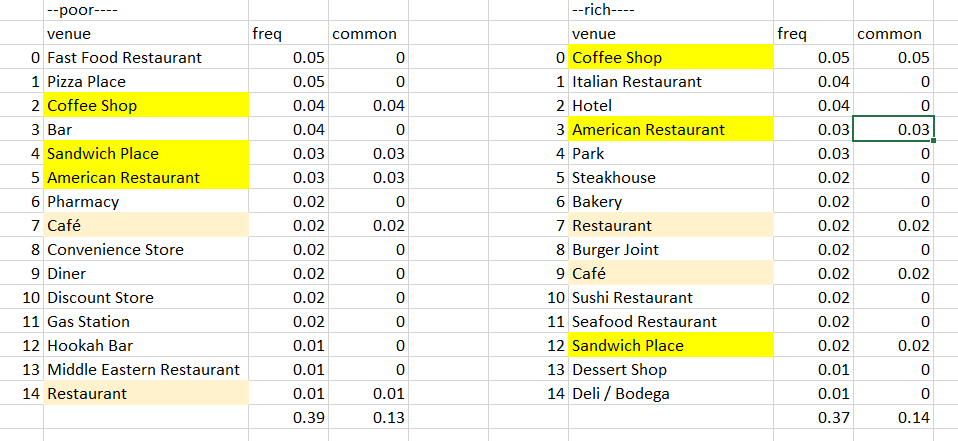
